# Data Handling Usage Guide

In [1]:
import random
import datetime
import os
import numpy as np
import h5py

from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt

### DOWNLOAD THESE FROM GIT OR CLOSE THE WHOLE REPOSITORY
### https://gitlab.com/deep.TEACHING/educational-materials/tree/master/notebooks/medical-image-classification
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, create_tumor_mask, rgb2gray, _create_otsu_mask_by_image
from preprocessing.util import TileMap

%matplotlib inline

### Data

The data used in this notebook are from the CAMELYON data sets, which are freely available on the [CAMELYON data page](https://camelyon17.grand-challenge.org/Data/).

The whole data sets have the following sizes:
- CAMELYON16 *(~715 GiB)*

For this notebook to work the following file structure inside the data set folders must be given:

```
data
├── CAMELYON16
    └── training
        ├── lesion_annotations
        │   └── tumor_001.xml - tumor_110.xml
        ├── normal
        │   └── normal_001.tif - normal_160.tif
        └── tumor
            └── tumor_001.tif - tumor_110.tif

```
**Note:** For the `SlideManager` class also uppercase and lowercase matters, especially to map annotations to tumor slides, so be consistant in file labeling. 

In [2]:
def print_slide_details(slide, level=0):
    print('Name: {}\n'
          'Size on layer {}: {:,} × {:,} pixel\n'
          'Layers: {}\n'
          'State: {}\n'
          'Annotations: {}'.format(level,
                                   slide.name,
                                   *slide.level_dimensions[level], # openslide method
                                   slide.level_count,          # openslide method
                                   slide.stage,
                                   len(slide.annotations)))
    

def plot_full_slide(slide, level = 3, w=15, h=15):
    img = slide.get_full_slide(level=level)
    plt.figure(figsize=(w, h))
    plt.imshow(img)
    

def plot_np_img(np_img, w=15, h=15):
    plt.figure(figsize=(w, h))
    plt.imshow(np_to_pil(np_img))

In [3]:
### Assign the path to your CAMELYON16 data and create the directories
CAM_BASE_DIR = '/media/nico/data/fourthbrain/project/'

In [4]:
### Do not edit this cell
CAM16_DIR = os.path.join(CAM_BASE_DIR, 'CAMELYON16')

In [5]:
# for minimal data set:
mgr = SlideManager(cam16_dir=CAM16_DIR)

print(mgr)

SlideManager contains: 356 Slides (111 annotated; 156 negative)


Name: 0
Size on layer tumor_001: 97,792 × 221,184 pixel
Layers: 10
State: None
Annotations: 2
Name: 4
Size on layer tumor_001: 6,112 × 13,824 pixel
Layers: 10
State: None
Annotations: 2


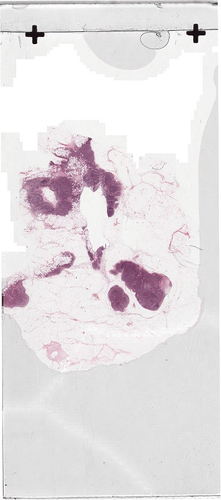

In [6]:
# let's take an ugly example of a cancerous slide with gray areas, and black marks on
slide_positive = mgr.annotated_slides[0]
full_slide_positive = slide_positive.get_full_slide(level=3)
print_slide_details(slide_positive, level=0)
print_slide_details(slide_positive, level=4)
slide_positive.get_thumbnail((500, 500))

In [7]:
# slide_negative = mgr.negative_slides[8]
# full_slide_negative = slide_negative.get_full_slide(level=1)
# print_slide_details(slide_negative, level=0)
# slide_negative.get_thumbnail((300, 300))

In [8]:
from preprocessing.histopath import pil_to_np_rgb, np_to_pil, filter_adaptive_equalization, filter_grays, mask_rgb, filter_remove_small_objects, filter_remove_small_holes, filter_rgb_to_grayscale, filter_otsu_threshold
from preprocessing.processing import remove_alpha_channel

In [14]:
def apply_image_filters_light(rgb, equalize=False, slide_num=None):
    """
    Apply filters to image as NumPy array
    """
    # EQUALIZATION CAN BE VERY SLOW - IMPOSSIBLE - ON HIGH DEFINITION Level 4 to 1. HUGE RAM CONSUMPTION

    if equalize:
        rgb = filter_adaptive_equalization(np_img, nbins=256, clip_limit=0.01, output_type="bool")
        
    mask_not_grays = filter_grays(np_img)
    mask_remove_objects = filter_remove_small_objects(mask_not_grays, min_size=5000, output_type="bool")
    mask_remove_holes = filter_remove_small_holes(mask_remove_objects, min_size=3000, output_type="bool")

    rgb = mask_rgb(rgb, mask_remove_holes)
    
    return rgb

In [9]:
def apply_image_filters(rgb, equalize=False, slide_num=None):
    """
    Apply filters to image as NumPy array
    """
    # EQUALIZATION CAN BE VERY SLOW - IMPOSSIBLE - ON HIGH DEFINITION Level 4 to 1. HUGE RAM CONSUMPTION

    if equalize:
        rgb = filter_adaptive_equalization(np_img, nbins=256, clip_limit=0.01, output_type="bool")
        
    mask_not_grays = filter_grays(np_img)
    mask_remove_objects = filter_remove_small_objects(mask_not_grays, min_size=5000, output_type="bool")
    mask_remove_holes = filter_remove_small_holes(mask_remove_objects, min_size=3000, output_type="bool")

    rgb = mask_rgb(rgb, mask_remove_holes)
    np_gray = rgb2gray(np_img)
    threshold = threshold_otsu(np_gray)
    mask = np_gray > threshold
    rgb = mask_rgb(rgb, mask)
    
    return rgb, mask

In [10]:
np_img = pil_to_np_rgb(full_slide_positive)
np_img = remove_alpha_channel(np_img)

RGB                  | Time: 0:00:00.665919  Type: uint8   Shape: (27648, 12224, 4)


In [16]:
np_img = apply_image_filters_light(np_img, equalize=False)

Remove Small Objs    | Time: 0:00:02.663629  Type: bool    Shape: (27648, 12224)
Remove Small Holes   | Time: 0:00:03.110073  Type: bool    Shape: (27648, 12224)
Mask RGB             | Time: 0:00:00.843045  Type: uint8   Shape: (27648, 12224, 3)


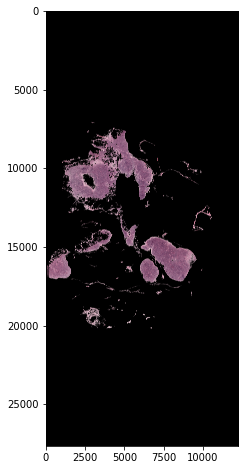

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(np_img)

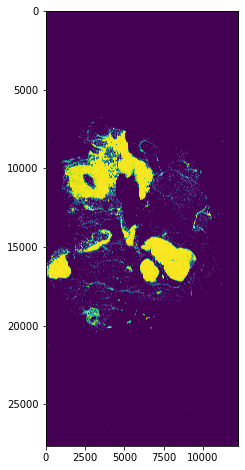

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(mask)

#### Annotations

Tumor annotations are represented by the `Annotation` class. Every `Annotation` object has a name and a polygon encompassing the tumor region. Annotated slides may have multiple `Annotation` objects.

The `Annotation` object can create an image of a tumor region with the polygon drawn over. Here the first 3 annotations of the first annotated slide:

In [ ]:
slide = mgr.annotated_slides[2]
print('Slide name: {}\n'.format(slide.name))
for annotation in slide.annotations[:]:
    bounds = annotation.get_boundaries(0)
    print('Annotation name: "{}"\n'
          'Position on layer 0: {}\n'
          'Size on layer 0: {:,} × {:,} pixel\n'.format(annotation.name,
                                                        bounds[0],
                                                        *bounds[1]))
    plt.figure()
    plt.imshow(annotation.get_image())
plt.show()

### Tiling

In general the file size and dimensions of a WSI are much bigger than a convolutional neural network can handle. To be able to predict the cancer status of tissue samples we need to cut each slide into small images, called tiles, which we can feed into a network as training data.

**Note:** Some preprocessing tasks take a lot of time. In order to reduce calculation time and play arround a bit more with the data we set the magnification `level=6` only. In the next notebooks we will work with much higher magnification though.

#### Negative slides

Negative tissue slides are slides of healthy tissue without any tumorous cells. 
From these negative slides we want to extract as many tiles with tissue as possible and ignore those with only background.

To split the background from the actual tissue data we can use an image processing algorithm based on the [Otsu Method](https://en.wikipedia.org/wiki/Otsu's_method) which is provided in the [scikit-image package](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu). This method calculates a threshold that divides a gray scale image into foreground and background.

As an example we can get a negative slide from the SlideManager:

In [ ]:
negative_slide = mgr.negative_slides[0]
print('Slide name: "{}"\n'
      'Tumorous: {}'.format(negative_slide.name,
                            negative_slide.has_tumor))
negative_slide.get_thumbnail((600, 600))

Now we can load the image into an NumPy array, convert it to gray scale and calculate the otsu threshold, though we will use another zoom level here.

In [ ]:
# load the slide into numpy array
arr = np.asarray(negative_slide.get_full_slide(level=3))
print('array shape:', arr.shape)

# convert it to gray scale
arr_gray = rgb2gray(arr)
print('gray array shape:', arr_gray.shape)

# calculate otsu threshold
threshold = threshold_otsu(arr_gray)
print('otsu threshold:',threshold)

The threshold splits the image into background and foreground. Pixels with a value lower are considered background and pixels with a higher value are considered foreground. To visualize this we can create a binary mask:

In [ ]:
# create an otsu mask
mask = arr_gray > threshold
plt.figure(figsize=(8,8))
plt.imshow(mask)

If we compare the mask with the slide thumbnail above we can see the algorithm successfully separated the pixels with tissue data from the background. The binary mask also allows us to count how many pixels of actual tissue data we have by summing it up:

In [ ]:
np.sum(mask)

In [ ]:
# gray

plt.figure(figsize=(8,8))
plt.imshow(arr_gray)

In [ ]:
arr_gray.max()

In [ ]:
arr_gray

This method to separate background from foreground by creating one binary mask works very well for smaller images and so far we have only been working on layer 6 of the WSI pyramid. But for lower layers with much higher dimension this step can be very memory intensive. To avoid this problem we can calculate the otsu threshold once and then create a mask based on that threshold for every tile of the slide individually.

The function `split_negative_slide` of the *preprocessing* module splits a slide into tiles with the specified dimensions. For each tile a binary mask is created based on the otsu threshold. If the sum of this mask is higher than the provided threshold, the tile and its boundaries are returned.

In [ ]:
tile_iter = split_negative_slide(
    negative_slide, level=3,
    otsu_threshold=threshold,  # otsu threshold calculated earlier
    tile_size=256,
    overlap=0,                 # no overlap
    poi_threshold=0.9)         # only select tiles with at least 90% tissue

# plot the first 3 tiles
plt.figure(figsize=(20, 6))
for i, (tile, bounds) in enumerate(tile_iter):
    print(bounds)          # tile boundaries on layer 0
    plt.subplot(1, 3, i+1)
    plt.imshow(tile)       # plot the tile

    if i >= 2:
        break


The `TileMap` class can be used to display the tiles and see which areas of the slide are selected. It's `image` attribute is an image of the WSI with all tiles marked:

In [ ]:
actual# initialize the map with the slide itself
tm = TileMap(negative_slide)

print('start splitting', datetime.datetime.now())
# create a new and unconsumed tile iterator
tile_iter = split_negative_slide(negative_slide, level=6,
                                 otsu_threshold=threshold,
                                 tile_size=32, 
                                 overlap=0,
                                 poi_threshold=0.2)
print('end splitting', datetime.datetime.now())

for _, bounds in tile_iter:
    # add the boundaries of every tile to the map
    #print('next tile', datetime.datetime.now())
    tm.add_tile(bounds)

tm.image

As you can see the green rectangles which represent a tile are only covering the area with tissue. With the `poi_threshold` parameter we can set the minimum amount of tissue each tile has (here 20%) and with the `overlap` parameter we can let the tiles overlap each other.

#### Positive slides

From positive slides we only want tiles with actual tumorous tissue to train our network. We can ignore the background and the rest of the tissue. We can use the same process we used for negative slides, but instead of a binary mask based on the otsu threshold, we can create a tumor masked based on the CAMELYON data set tumor annotations.


In [ ]:
positive_slide = mgr.get_slide('tumor_110')
print('Slide name: "{}"'.format(positive_slide.name))
positive_slide.get_thumbnail((500, 500))

In [ ]:
mask = create_tumor_mask(positive_slide, level=2)
plt.imshow(mask)

The function `create_tumor_mask` takes the polygons from all annotations and creates a binary mask were $0$ represents healthy and $1$ tumorous tissue.

*Note: Micro and macro metastases in the CAMELYON data set are annotated exhaustively. However, there might be isolated tumor cells (ITCs) that are not annotated at all. For this reason we only want to use the annotated areas from positive slides as positive tiles and we don't want to use the remaining tissue as negative tiles.*

As with the otsu mask for negative slides, creating a tumor mask of a whole slide on a low layer might lead to memory issues. To prevent that we will only generate partial tumor mask for each tile we process.

The `split_positive_slide` function provides this. As an example we can again split a slide into $128\times128$ tiles on layer 5 and use the `TileMap` to display the result:

In [ ]:
level = 6
tile_size = 128

tile_iter = split_positive_slide(
    positive_slide, level=level,
    tile_size=tile_size,  
    overlap=32)      # no overlap

tm = TileMap(positive_slide)
for _, bounds in tile_iter:
    # add the boundaries of every tile to the map
    tm.add_tile(bounds)

print('Created {} tiles.'.format(len(tm.tiles)))
tm.image

### Storing

Finally we need to store the preprocessed data in a way we can easily read out and feed into the CNN.

The HDF5-format (Hierarchical Data Format version 5) is a data format designed to store and organize large amounts of data on the hard drive. For python the package [h5py](http://www.h5py.org/) offers a rich API around HDF5 that allows us to store and load sets of data very similar to the way we handle NumPy ndarrays.

As an example, let us store one example slide into HDF5:

First, we need to create a new tile iterator. This time we want all the tiles with at least 5% of tissue and a small overlap of 5 pixels. To be able to see which tiles are written we will make a new `TileMap` as well.

In [ ]:
# create a new and unconsumed tile iterator
tile_size = 128
tile_iter = split_negative_slide(negative_slide, level=3,
                                 otsu_threshold=threshold,
                                 tile_size=tile_size, overlap=5,
                                 poi_threshold=0.05)

# initialize map
tm = TileMap(negative_slide)

In [ ]:
filename = '{}/just_a_testfile_can_be_deleted.hdf5'.format(CAM16_DIR, negative_slide.name, level)
label = 0                                              

with h5py.File(filename, "w", libver='latest') as h5:  
    # creating a date set in the file
    dset = h5.create_dataset('data',                                   
        (0, tile_size, tile_size, 3),                             
        dtype=np.uint8,                                
        maxshape=(None, tile_size, tile_size, 3),                  
        compression="lzf")                             
    
    lset = h5.create_dataset('label', (0,),            
                             maxshape=(None,),
                             dtype=np.uint8)
    cur = 0
    for tile, bounds in tile_iter:                     
        dset.resize(cur + 1, axis=0)                    
        dset[cur:cur + 1] = tile                        

        lset.resize(cur + 1, axis=0)                   
        lset[cur:cur + 1] = label

        cur += 1
        tm.add_tile(bounds)                            
        print('.', end='')

print('\n{} tiles written'.format(cur))
tm.image

Issue a shell command to see how many bytes have been written.

In [ ]:
!ls -l {filename} | cut -d' ' -f5,9

Now we can see what has been written to the file:

In [ ]:
with h5py.File(filename, 'r') as h5:
    for key in h5.keys():
        print('Datasets "{}", shape: {}'.format(key, h5[key].shape))

The numbers match, we can read out five random tiles and their labels:

In [ ]:
classes = ('negative', 'positive')

plt.figure(figsize=(20, 6))
with h5py.File(filename, 'r') as h5:
    rand_indexes = random.sample(range(len(h5['data'])), k=5)
    for i, idx in enumerate(rand_indexes):
        plt.subplot(1, 5, i+1)
        plt.imshow(h5['data'][idx])
        plt.title(classes[h5['label'][idx]])